In [1]:
import os.path as op
import sys
sys.path.append(op.abspath('../'))

In [2]:
import models, var
from project import files, defs
from lib import plot as lp
from lib.data import compute_vals
import matplotlib.pyplot as plt
import numpy as np

In [3]:
## Random generator
rng = np.random.default_rng(12345)

In [4]:
B = 100000
S = 100000

shift_pedestal = (600, 150)
amp_S = np.abs(rng.normal(loc=25, scale=5, size=S))

In [5]:
dataframe = models.get_sig_bkg_dataframe(
    S=S, B=B, amp_S=amp_S,
    shift_pedestal=shift_pedestal,
    random_time_shift=True,
    rng=rng
)
dataframe

s0     s1     s2     s3     s4     s5     s6     s7     s8     s9  \
0      584.0  582.0  595.0  597.0  588.0  582.0  580.0  581.0  580.0  581.0   
1      785.0  807.0  812.0  795.0  785.0  781.0  781.0  781.0  781.0  783.0   
2      629.0  629.0  631.0  644.0  649.0  636.0  631.0  629.0  627.0  625.0   
3      531.0  528.0  529.0  546.0  553.0  536.0  529.0  528.0  527.0  528.0   
4      480.0  478.0  481.0  497.0  500.0  488.0  480.0  476.0  475.0  476.0   
...      ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
99995  613.0  612.0  613.0  612.0  612.0  612.0  613.0  612.0  614.0  611.0   
99996  488.0  487.0  487.0  487.0  489.0  489.0  488.0  489.0  491.0  488.0   
99997  651.0  651.0  653.0  652.0  652.0  652.0  652.0  653.0  652.0  654.0   
99998  724.0  723.0  723.0  723.0  724.0  724.0  724.0  724.0  721.0  723.0   
99999  503.0  500.0  502.0  501.0  504.0  503.0  503.0  502.0  502.0  503.0   

       ...    s24    s25    s26    s27    s28    s29    s30    s31  is_sig  \
0      ...  582.0  582.0  583.0  581.0  583.0  584.0  584.0  583.0    True   
1      ...  785.0  784.0  784.0  785.0  785.0  787.0  786.0  785.0    True   
2      ...  629.0  627.0  629.0  628.0  629.0  630.0  631.0  629.0    True   
3      ...  530.0  530.0  530.0  531.0  530.0  531.0  529.0  532.0    True   
4      ...  479.0  480.0  479.0  479.0  479.0  480.0  478.0  477.0    True   
...    ...    ...    ...    ...    ...    ...    ...    ...    ...     ...   
99995  ...  613.0  613.0  615.0  611.0  612.0  612.0  613.0  613.0   False   
99996  ...  490.0  490.0  487.0  487.0  489.0  487.0  488.0  488.0   False   
99997  ...  652.0  650.0  651.0  652.0  652.0  650.0  651.0  651.0   False   
99998  ...  724.0  723.0  724.0  722.0  723.0  724.0  722.0  722.0   False   
99999  ...  502.0  502.0  502.0  503.0  501.0  503.0  502.0  502.0   False   

       is_bkg  
0       False  
1       False  
2       False  
3       False  
4       False  
...       ...  
99995    True  
99996    True  
99997    True  
99998    True  
99999    True  

[200000 rows x 34 columns]

In [6]:
dataframe = files.compute_voi(
    dataframe,
    variables=defs.computed_variables + ['lower_than_mean_cons', 'larger_than_mean_cons']
)

Time taken: 0.9747083187103271


In [7]:
dataframe = compute_vals(dataframe, var.plot_columns)
voi = ['max - mean', 'lower_than_mean_cons', 'std']
dataframe[voi]

max - mean  lower_than_mean_cons       std
0        14.71875                  17.0  4.109702
1        26.84375                  19.0  6.978133
2        19.28125                  15.0  4.810369
3        23.03125                  17.0  5.564870
4        20.93750                  16.0  5.689560
...           ...                   ...       ...
99995     3.18750                   3.0  1.210307
99996     2.65625                   4.0  1.134939
99997     2.25000                   2.0  1.030776
99998     1.06250                   2.0  0.966227
99999     1.81250                  10.0  0.916430

[200000 rows x 3 columns]

In [8]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from time import time
from sklearn import metrics
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [9]:
def bench_k_means(kmeans, name, data, labels):
    """Benchmark to evaluate the KMeans initialization methods.

    Parameters
    ----------
    kmeans : KMeans instance
        A :class:`~sklearn.cluster.KMeans` instance with the initialization
        already set.
    name : str
        Name given to the strategy. It will be used to show the results in a
        table.
    data : ndarray of shape (n_samples, n_features)
        The data to cluster.
    labels : ndarray of shape (n_samples,)
        The labels used to compute the clustering metrics which requires some
        supervision.
    """
    t0 = time()
    estimator = make_pipeline(StandardScaler(), kmeans).fit(data)
    fit_time = time() - t0
    results = [name, fit_time, estimator[-1].inertia_]

    # Define the metrics which require only the true labels and estimator
    # labels
    clustering_metrics = [
        metrics.homogeneity_score,
        metrics.completeness_score,
        metrics.v_measure_score,
        metrics.adjusted_rand_score,
        metrics.adjusted_mutual_info_score,
    ]
    results += [m(labels, estimator[-1].labels_) for m in clustering_metrics]

    # The silhouette score requires the full dataset
    results += [
        metrics.silhouette_score(
            data,
            estimator[-1].labels_,
            metric="euclidean",
            sample_size=300,
        )
    ]

    # Show the results
    formatter_result = (
        "{:9s}\t{:.3f}s\t{:.0f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}"
    )
    print(formatter_result.format(*results))

In [10]:
df = dataframe[voi]
labels = dataframe['is_sig']

print(82 * "_")
print("init\t\ttime\tinertia\thomo\tcompl\tv-meas\tARI\tAMI\tsilhouette")

kmeans = KMeans(init = "k-means++", n_clusters = 2, n_init = 4, random_state = 0)
bench_k_means(kmeans=kmeans, name="k-means++", data=df, labels=labels)

kmeans = KMeans(init = "random", n_clusters = 2, n_init = 4, random_state = 0)
bench_k_means(kmeans=kmeans, name="random", data=df, labels=labels)

pca = PCA(n_components = 2).fit(df)
kmeans = KMeans(init = pca.components_, n_clusters = 2, n_init = 1)
bench_k_means(kmeans=kmeans, name="PCA-based", data=df, labels=labels)

print(82 * "_")

__________________________________________________________________________________
init		time	inertia	homo	compl	v-meas	ARI	AMI	silhouette
k-means++	0.655s	64791	0.955	0.955	0.955	0.977	0.955	0.807
random   	0.250s	64791	0.955	0.955	0.955	0.977	0.955	0.798
PCA-based	0.153s	64791	0.955	0.955	0.955	0.977	0.955	0.810
__________________________________________________________________________________


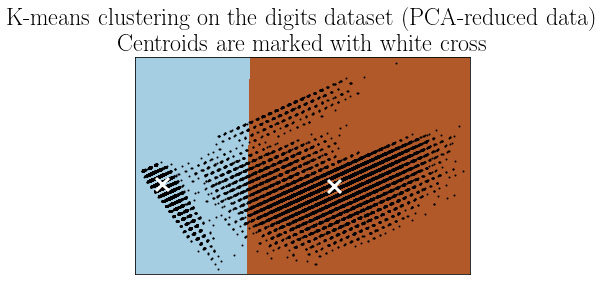

In [11]:
reduced_data = PCA(n_components=2).fit_transform(df)
kmeans = KMeans(init="k-means++", n_clusters=2, n_init=4)
kmeans.fit(reduced_data)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = 0.02  # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(
    Z,
    interpolation="nearest",
    extent=(xx.min(), xx.max(), yy.min(), yy.max()),
    cmap=plt.cm.Paired,
    aspect="auto",
    origin="lower",
)

plt.plot(reduced_data[:, 0], reduced_data[:, 1], "k.", markersize=2)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(
    centroids[:, 0],
    centroids[:, 1],
    marker="x",
    s=169,
    linewidths=3,
    color="w",
    zorder=10,
)
plt.title(
    "K-means clustering on the digits dataset (PCA-reduced data)\n"
    "Centroids are marked with white cross"
)
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

In [12]:
labels_signals = kmeans.labels_[0:99999]
labels_bkg = kmeans.labels_[100000:-1]
dict_signals = {}
dict_bkg = {}

for label in np.unique(labels_signals):
    dict_signals[label] = len(labels_signals[labels_signals==label])

for label in np.unique(labels_bkg):
    dict_bkg[label] = len(labels_bkg[labels_bkg==label])
    
dict_signals, dict_bkg

({1: 99013, 0: 986}, {0: 99999})

## Conclusion
The K-Means clustering seems to be very effective as it labeled all background samples the same (label = 1) and 99% of the signals as signals (label = 0).

In [13]:
dataframe2 = models.get_sig_bkg_dataframe(
    S=S, B=B*10, amp_S=amp_S,
    shift_pedestal=shift_pedestal,
    random_time_shift=True,
    rng=rng
)
dataframe2 = files.compute_voi(
    dataframe2,
    variables=defs.computed_variables + ['lower_than_mean_cons', 'larger_than_mean_cons']
)
dataframe2 = compute_vals(dataframe2, var.plot_columns)
dataframe2[voi]

Time taken: 2.7758631706237793


max - mean  lower_than_mean_cons       std
0         14.93750                   1.0  3.920599
1         28.96875                  20.0  7.269304
2         18.84375                  19.0  4.835477
3         19.15625                  14.0  5.196810
4         20.06250                  16.0  5.177702
...            ...                   ...       ...
999995     2.09375                   2.0  1.182143
999996     2.12500                   3.0  1.243734
999997     2.06250                   3.0  1.087931
999998     1.93750                   4.0  0.899218
999999     2.12500                   5.0  1.192424

[1100000 rows x 3 columns]

In [14]:
df_big = dataframe2[voi]
labels_big = dataframe2['is_sig']

print(82 * "_")
print("init\t\ttime\tinertia\thomo\tcompl\tv-meas\tARI\tAMI\tsilhouette")

kmeans = KMeans(init = "k-means++", n_clusters = 2, n_init = 4, random_state = 0)
bench_k_means(kmeans=kmeans, name="k-means++", data=df_big, labels=labels_big)

kmeans = KMeans(init = "random", n_clusters = 2, n_init = 4, random_state = 0)
bench_k_means(kmeans=kmeans, name="random", data=df_big, labels=labels_big)

pca = PCA(n_components = 2).fit(df_big)
kmeans = KMeans(init = pca.components_, n_clusters = 2, n_init = 1)
bench_k_means(kmeans=kmeans, name="PCA-based", data=df_big, labels=labels_big)

print(82 * "_")

__________________________________________________________________________________
init		time	inertia	homo	compl	v-meas	ARI	AMI	silhouette
k-means++	1.154s	465122	0.976	0.983	0.979	0.993	0.979	0.867
random   	0.760s	465122	0.976	0.983	0.979	0.993	0.979	0.872
PCA-based	0.834s	465122	0.976	0.983	0.979	0.993	0.979	0.879
__________________________________________________________________________________


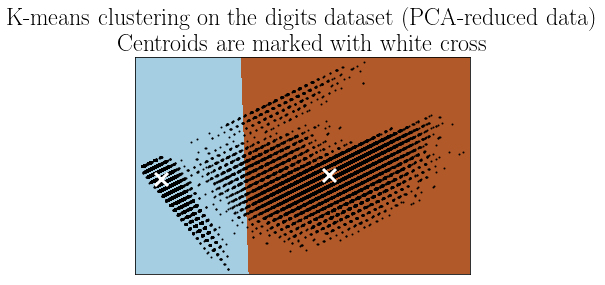

In [15]:
reduced_data = PCA(n_components=2).fit_transform(df_big)
kmeans = KMeans(init="k-means++", n_clusters=2, n_init=4)
kmeans.fit(reduced_data)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = 0.02  # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(
    Z,
    interpolation="nearest",
    extent=(xx.min(), xx.max(), yy.min(), yy.max()),
    cmap=plt.cm.Paired,
    aspect="auto",
    origin="lower",
)

plt.plot(reduced_data[:, 0], reduced_data[:, 1], "k.", markersize=2)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(
    centroids[:, 0],
    centroids[:, 1],
    marker="x",
    s=169,
    linewidths=3,
    color="w",
    zorder=10,
)
plt.title(
    "K-means clustering on the digits dataset (PCA-reduced data)\n"
    "Centroids are marked with white cross"
)
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

In [16]:
labels_signals = kmeans.labels_[0:100000]
labels_bkg = kmeans.labels_[100000:]
dict_signals = {}
dict_bkg = {}

for label in np.unique(labels_signals):
    dict_signals[label] = len(labels_signals[labels_signals==label])

for label in np.unique(labels_bkg):
    dict_bkg[label] = len(labels_bkg[labels_bkg==label])
    
dict_signals, dict_bkg

({0: 945, 1: 99055}, {0: 1000000})

# Conclusion 2
The K-Means clustering seems to work as well when there are fewer signals in comparison to background samples.

# Test on real data

In [17]:
import lib.rootdata as lrd
import lib.plot as lp

In [18]:
run = "00405127"
num = "0644" # id of the file for the given run

# Eta and layer to keep
# eta = 0.05
# layer = 0
eta = None
layer = 2

In [19]:
file_path = files.get_path_run_num(run=run, num=num)

# Given {rapidity} and given {layer}
dataframe = lrd.load_ROOT_into_dataframe(
    file_path, 
    tree_name=defs.unproc_tree_name,
    variables=defs.unproc_kept_variables,
    cut=files.get_cut(eta=eta, layer=layer),
)

/mnt/c/900GeV/
Number of events in the dataframe 5819520
Time taken to load the ROOT files: 38.29582667350769
ROOT files loaded: /mnt/c/900GeV/00405127/atlas/data21_900GeV.00405127.physics_L1Calo.merge.RAW._lb0644._SFO-ALL._0001.root


In [20]:
dataframe = files.process_dataframe(dataframe)

Remove NaN events
5196 events removed out of 5819520 -> efficiency 0.0008928571428571428
Time taken: 116.49643015861511


In [21]:
dataframe = files.compute_voi(
    dataframe,
    variables=defs.computed_variables + ['lower_than_mean_cons', 'larger_than_mean_cons']
)
dataframe = compute_vals(dataframe, var.plot_columns)
voi = ['max - mean', 'lower_than_mean_cons', 'std']
dataframe[voi]

Time taken: 62.3614227771759


max - mean  lower_than_mean_cons       std
0           0.93750                   6.0  0.609175
1           0.56250                   4.0  0.496078
2           2.00000                   1.0  0.500000
3           0.31250                   3.0  0.463512
4           1.12500                   3.0  0.414578
...             ...                   ...       ...
5819515     0.56250                   7.0  0.555512
5819516     1.00000                   1.0  0.250000
5819517     2.59375                   6.0  1.168850
5819518     0.03125                   1.0  0.173993
5819519     0.37500                   4.0  0.484123

[5813891 rows x 3 columns]

In [22]:
df = dataframe[voi]

reduced_data = PCA(n_components=2).fit_transform(df)
kmeans = KMeans(init="k-means++", n_clusters=2, n_init=4)
kmeans.fit(reduced_data)

KMeans(n_clusters=2, n_init=4)

In [23]:
labels_samples = kmeans.labels_
dict_samples = {}

for label in np.unique(labels_samples):
    dict_samples[label] = len(labels_samples[labels_samples==label])

dict_samples

{0: 4654939, 1: 1158952}

In [24]:
dataframe['label'] = kmeans.labels_

In [25]:
dataframe_1 = dataframe.query('label==1')
dataframe_0 = dataframe.query('label==0')

(<Figure size 576x432 with 1 Axes>,
 <AxesSubplot:xlabel='Time increment', ylabel='Output'>)

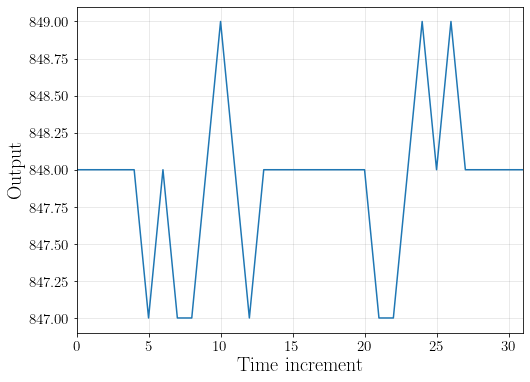

In [26]:
lp.plot_event(dataframe_0.iloc[85])

In [27]:
dataframe_signal = dataframe.query("abs(mean - pedestal) < 10")
dataframe_signal = dataframe_signal.query("(std > 4)")

0.0

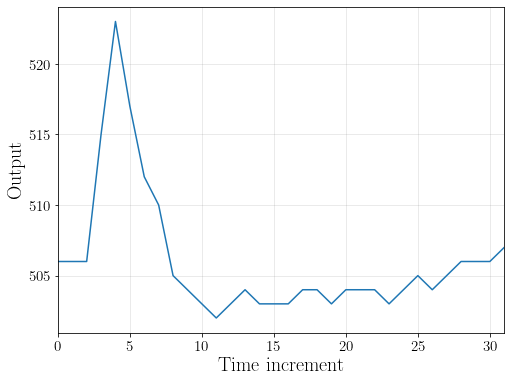

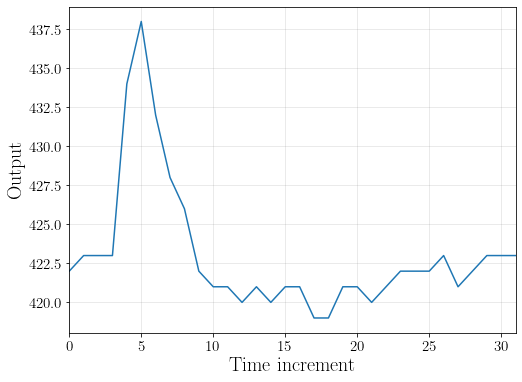

In [28]:
lp.plot_event(dataframe_signal.iloc[0])
dataframe_signal.iloc[0]['label']
lp.plot_event(dataframe_signal.iloc[1])
dataframe_signal.iloc[1]['label']

# Conclusion
Unfortunately the K-Means clustering does not seem to recognize the signals amongst the samples.